<a href="https://colab.research.google.com/github/kaichyuan/data-science-portfolio/blob/master/Business_Card_OCR_with_Convolutional_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Business Card OCR with Convolutional Neural Network
I have a stash of business cards lying in the corner of my drawer that I've been meaning to organize and digitize onto my phone. Well, typing them manually is possible, but it's the 21st century and I thought I'd do something a bit fancier—like automating it. I'd like to snap a picture of the business card, run it through a deep learning model to detect and recognize the relevant information, and then magically populates the contact fields.

* [Method 1 (Libraries)](#libraries-method)
  * [Text Detection With OpenCV](#opencv)
  * [Text Recognition With Pytesseract](#pytesseract)
*[Method 2 (Custom Model](#custom-model-method)
  * [Preparing the Data](#preparing-data)
  * [Building the CNN Model](#building-model)
  * [Training the CNN Model](#training-model)
  * [Evaluating the CNN Model](#evaluating-model)
  * [Testing the CNN Model](#testing-model)
  * [Future Improvement](#future-improvement)


In [1]:
import pandas as pd
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm

import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

!pip install pytesseract
!sudo apt install tesseract-ocr
import pytesseract
pytesseract.pytesseract.tesseract_cmd = (r'/usr/bin/tesseract')

import cv2

from PIL import Image

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.00~git2288-10f4998a-2).
0 upgraded, 0 newly installed, 0 to remove and 31 not upgraded.


## Method 1 (Libraries) <a name="libraries-method"></a>

There are ready-made tools out there that helps us (i) detect and (ii) recognize texts in images. For example, we can use **OpenCV** for text detection and **Pytesseract** for image recognition.

### Text Detection With OpenCV <a name="opencv"></a>

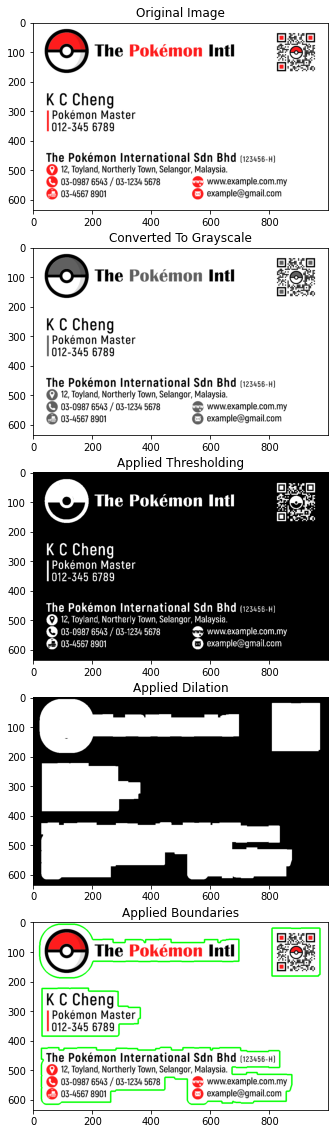

In [2]:
img = cv2.imread("namecard_example.jpg")

# Initialize image plots
fig, ax = plt.subplots(5, figsize=(40,20))

# Convert image from BGR back to RGB for display
ax[0].imshow(img[...,::-1])
ax[0].title.set_text('Original Image')

# Convert the image to gray scale
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ax[1].imshow(gray_img, cmap='gray', vmin=0, vmax=255)
ax[1].title.set_text('Converted To Grayscale')

# Performing OTSU threshold
ret, thresh1 = cv2.threshold(gray_img, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)
ax[2].imshow(thresh1, cmap='gray', vmin=0, vmax=255)
ax[2].title.set_text('Applied Thresholding')

# Specify structure shape and kernel size.
rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (35,35))

# Appplying dilation on the threshold image
dilated_img = cv2.dilate(thresh1, rect_kernel, iterations=1)
ax[3].imshow(dilated_img, cmap='gray', vmin=0, vmax=255)
ax[3].title.set_text('Applied Dilation')

# Finding contours
contours, hierarchy = cv2.findContours(dilated_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

# Creating a copy of image
img_copy = img[...,::-1].copy()

# Outlining detected boundaries
cv2.drawContours(img_copy, contours, -1, (0,255,0), 3)
ax[4].imshow(img_copy, 'gray', vmin=0, vmax=255)
ax[4].title.set_text('Applied Boundaries')

### Text Recognition With Pytesseract <a name="pytesseract"></a>

predicted text:
 The Pokémon International Sdn Bhd (123456-n)
Q 12, Toyland, Northerly Town, Selangor, Malaysia.

@ 03-0987 6543 / 03-1234 5678 @ wwwexample.com.my
© 03-4567 8901 © example@gmail.com
 

predicted text:
 K C Cheng

Pokémon Master
012-345 6789
 

predicted text:
  
 

predicted text:
 & The Pokémon Intl
 



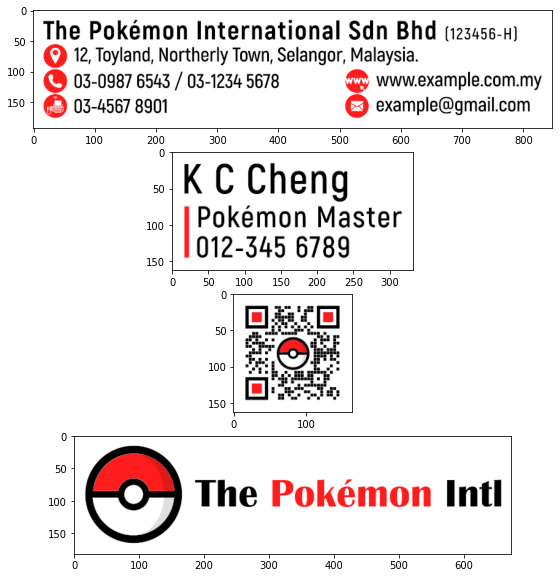

In [3]:
# Initialize the plot
num_of_predictions = len(contours)
fig, ax = plt.subplots(num_of_predictions, figsize=(10,10))    
    
for idx, cnt in enumerate(contours):
    x, y, w, h = cv2.boundingRect(cnt)

    # Convert image from BGR back to RGB for display
    img_ori = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Cropping the text block for giving input to OCR
    cropped = img_ori[y:y+h, x:x+w]
    ax[idx].imshow(cropped)

    # Apply OCR on the cropped image
    text = pytesseract.image_to_string(cropped)
    print('predicted text:\n', text, '\n')

There we go. With just a little bit of cleaning and a classifier to group these texts into phone number, company name, etc and we have ourselves a business card reader.

## Method 2 (Custom Model) <a name="custom-model-method"></a>

OpenCV and Pytesseract are really powerful libraries and they should suffice for most general applications. But being the rebel that I am, I'd like to try to build my own model to achieve the same thing. Why? Partly because I thought it's interesting to learn the underlying nuts and bolts of these libraries, and partly because I want to have more control over the model.

### Preparing the Data <a name="preparing-data"></a>
To build our own model from scratch, I'll be using the MNIST database. It has over 70,000 examples of handwritten digits and they are available at http://yann.lecun.com/exdb/mnist/. This will help our model to learn to read numbers. Alphabets can come at a later stage with similar approach.

In [4]:
# Import MNIST data.
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data(path='mnist.npz')

In [5]:
# One hot encode the labels "0" to "9"
onehot_encoder = OneHotEncoder(sparse=False)

y_train = y_train.reshape(len(y_train), 1)
y_train = onehot_encoder.fit_transform(y_train)

y_test = y_test.reshape(len(y_test), 1)
y_test = onehot_encoder.fit_transform(y_test)

In [6]:
# Create training & validation set with data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    validation_split=0.2
)

training_set = train_datagen.flow(
    x=X_train.reshape((X_train.shape[0], 28, 28, 1)),
    y=y_train,
    subset='training'
)

valid_set = train_datagen.flow(
    x=X_train.reshape((X_train.shape[0], 28, 28, 1)),
    y=y_train,
    subset='validation'
)

# Create testing set
test_datagen = ImageDataGenerator(
    rescale=1./255
)

test_set = test_datagen.flow(
    x=X_test.reshape((X_test.shape[0], 28, 28, 1)),
    y=y_test,
    shuffle=False
)

### Building the CNN Model <a name="building-model"></a>


In [7]:
cnn = tf.keras.models.Sequential()
cnn.add(tf.keras.layers.Conv2D(filters=16, kernel_size=3, activation='relu', kernel_initializer='he_uniform',input_shape=(28, 28, 1), padding='same'))
cnn.add(tf.keras.layers.BatchNormalization())
cnn.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2))

cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', kernel_initializer='he_uniform',input_shape=(28, 28, 1), padding='same'))
cnn.add(tf.keras.layers.BatchNormalization())
cnn.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2))

cnn.add(tf.keras.layers.Flatten())

cnn.add(tf.keras.layers.Dense(units=100, activation='relu', kernel_initializer='he_uniform'))
cnn.add(tf.keras.layers.BatchNormalization())
cnn.add(tf.keras.layers.Dense(units=10, activation='softmax'))

In [8]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 16)        64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1568)              0

### Training the CNN Model <a name="training-model"></a>

In [9]:
# Implement early stopping
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

In [10]:
# Training the model
opt = tf.keras.optimizers.Adam(learning_rate=0.01)
cnn.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

my_model = cnn.fit(x=training_set, validation_data=valid_set, epochs=40, batch_size=32, verbose=2, callbacks=[es])

Epoch 1/40
1500/1500 - 59s - loss: 0.1318 - accuracy: 0.9599 - val_loss: 0.1040 - val_accuracy: 0.9673
Epoch 2/40
1500/1500 - 58s - loss: 0.0795 - accuracy: 0.9758 - val_loss: 0.0783 - val_accuracy: 0.9764
Epoch 3/40
1500/1500 - 58s - loss: 0.0599 - accuracy: 0.9811 - val_loss: 0.0890 - val_accuracy: 0.9735
Epoch 4/40
1500/1500 - 58s - loss: 0.0519 - accuracy: 0.9834 - val_loss: 0.1240 - val_accuracy: 0.9688
Epoch 5/40
1500/1500 - 59s - loss: 0.0482 - accuracy: 0.9852 - val_loss: 0.0764 - val_accuracy: 0.9795
Epoch 6/40
1500/1500 - 59s - loss: 0.0423 - accuracy: 0.9864 - val_loss: 0.0492 - val_accuracy: 0.9859
Epoch 7/40
1500/1500 - 60s - loss: 0.0395 - accuracy: 0.9875 - val_loss: 0.0983 - val_accuracy: 0.9826
Epoch 8/40
1500/1500 - 61s - loss: 0.0375 - accuracy: 0.9882 - val_loss: 0.0544 - val_accuracy: 0.9852
Epoch 9/40
1500/1500 - 61s - loss: 0.0351 - accuracy: 0.9893 - val_loss: 0.0506 - val_accuracy: 0.9853
Epoch 10/40
1500/1500 - 62s - loss: 0.0328 - accuracy: 0.9904 - val_loss:

### Evaluating the CNN Model <a name="evaluating-model"></a>

First, I wanted to know if our model was over/under fitted so I plotted our models' accuracies and losses to compare the training set against validation set.

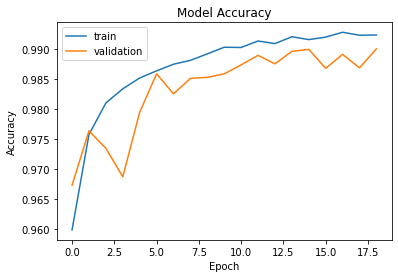

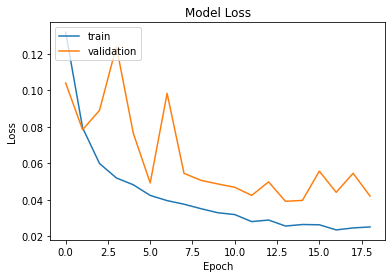

In [11]:
# Summarize history for accuracy
plt.plot(my_model.history['accuracy'])
plt.plot(my_model.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Summarize history for loss
plt.plot(my_model.history['loss'])
plt.plot(my_model.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

When we test our model with the 10,000 testing images from MNIST, the model accuracy remains robust at 99% accuracy. There are no real major issues but if we had to nitpick, it's interesting to note that our model tend to mix up similar shaped digits such as "5" and "9", "4" and "9".

313/313 [==============================] - 4s 13ms/step - loss: 0.0296 - accuracy: 0.9923


Text(0.5, 69.0, 'True Value')

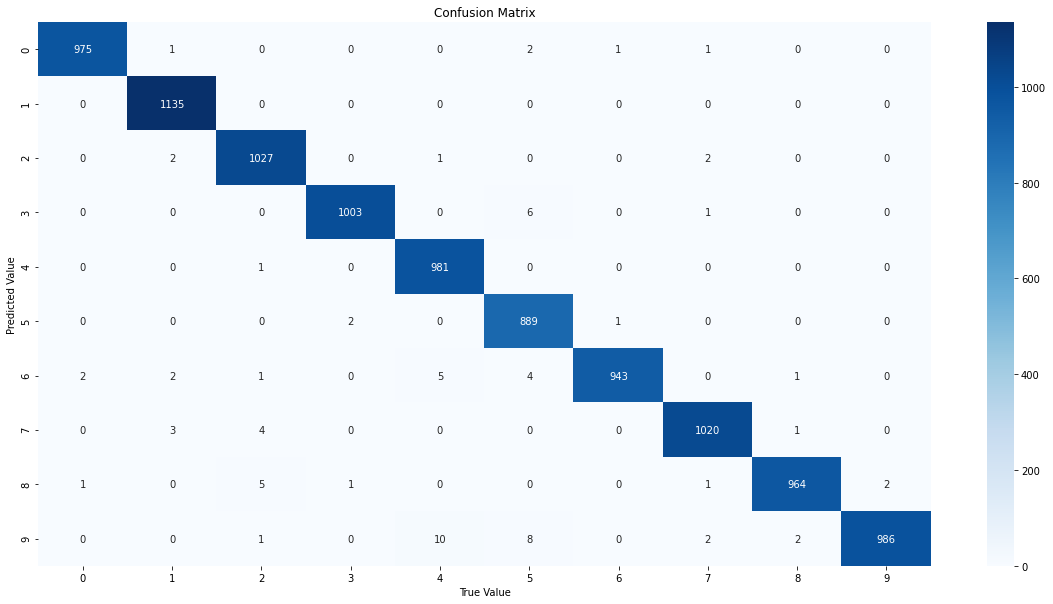

In [12]:
predictions = cnn.predict(test_set)

# Evaluate accuracy score on test_set
score = cnn.evaluate(test_set)

# Plot confusion matrix
cm = confusion_matrix(y_test.argmax(axis=1), predictions.argmax(axis=1))
df_cm = pd.DataFrame(cm, index = [i for i in "0123456789"], columns = [i for i in "0123456789"])
plt.figure(figsize = (20,10))
ax = sns.heatmap(df_cm, annot=True, fmt='g', cmap="Blues")
ax.set_title('Confusion Matrix')
plt.ylabel('Predicted Value')
plt.xlabel('True Value')

In [13]:
target_names = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
report = classification_report(y_test.argmax(axis=1), predictions.argmax(axis=1))
print(report)

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       980
           1       0.99      1.00      1.00      1135
           2       0.99      1.00      0.99      1032
           3       1.00      0.99      1.00      1010
           4       0.98      1.00      0.99       982
           5       0.98      1.00      0.99       892
           6       1.00      0.98      0.99       958
           7       0.99      0.99      0.99      1028
           8       1.00      0.99      0.99       974
           9       1.00      0.98      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



### Testing the CNN Model <a name="testing-model"></a>

Although the model did fairly well against the test set provided by MNIST, I wanted to verify its robustness by using my own images. So, I summoned all my artistry cells to slap together a few variations of font type, size, colors, angles onto a .jpg file. 

I'll use OpenCV to process the image, detect the numbers and then fit them into our model.

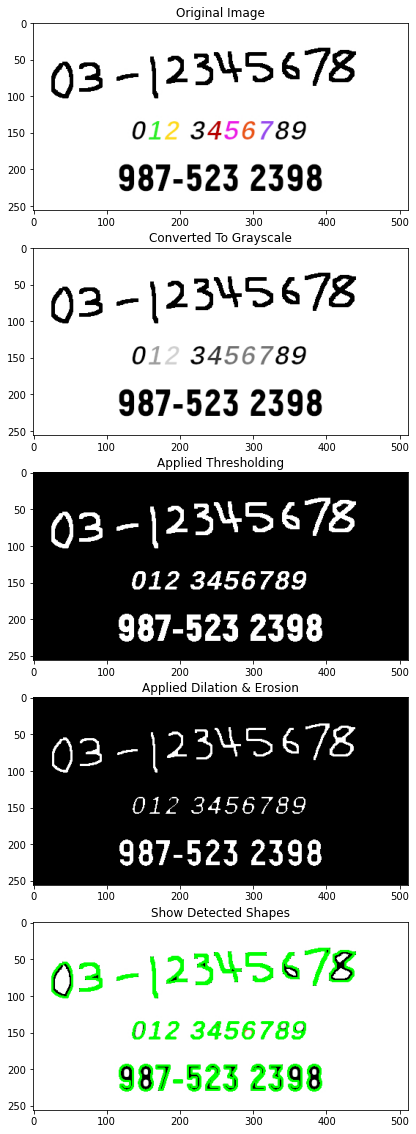

In [14]:
img_ori = cv2.imread("phone_number.jpg")

fig, ax = plt.subplots(5, figsize=(40,20))

# Convert image from BGR back to RGB for display
ax[0].imshow(img_ori[...,::-1])
ax[0].title.set_text('Original Image')

# Convert the image to gray scale
gray_img = cv2.cvtColor(img_ori, cv2.COLOR_BGR2GRAY)
ax[1].imshow(gray_img, cmap='gray', vmin=0, vmax=255)
ax[1].title.set_text('Converted To Grayscale')

# Apply thresholding
ret, thresh1 = cv2.threshold(gray_img, 245, 255, cv2.THRESH_BINARY_INV)
ax[2].imshow(thresh1, cmap='gray', vmin=0, vmax=255)
ax[2].title.set_text('Applied Thresholding')

# Apply morphology
rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
morphed_img = cv2.morphologyEx(thresh1, cv2.MORPH_CLOSE, rect_kernel)

# Appply dilation
dilated_img = cv2.dilate(morphed_img, rect_kernel, iterations=1)
processed_img = cv2.erode(dilated_img, rect_kernel, iterations=2)
ax[3].imshow(processed_img, cmap='gray', vmin=0, vmax=255)
ax[3].title.set_text('Applied Dilation & Erosion')

# Finding contours
contours, hierarchy = cv2.findContours(processed_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

# Creating a copy of image
img_copy = img_ori[...,::-1].copy()

# Draw Contours
cv2.drawContours(img_copy, contours, -1, (0,255,0), 2)
ax[4].imshow(img_copy, 'gray', vmin=0, vmax=255)
ax[4].title.set_text('Show Detected Shapes')

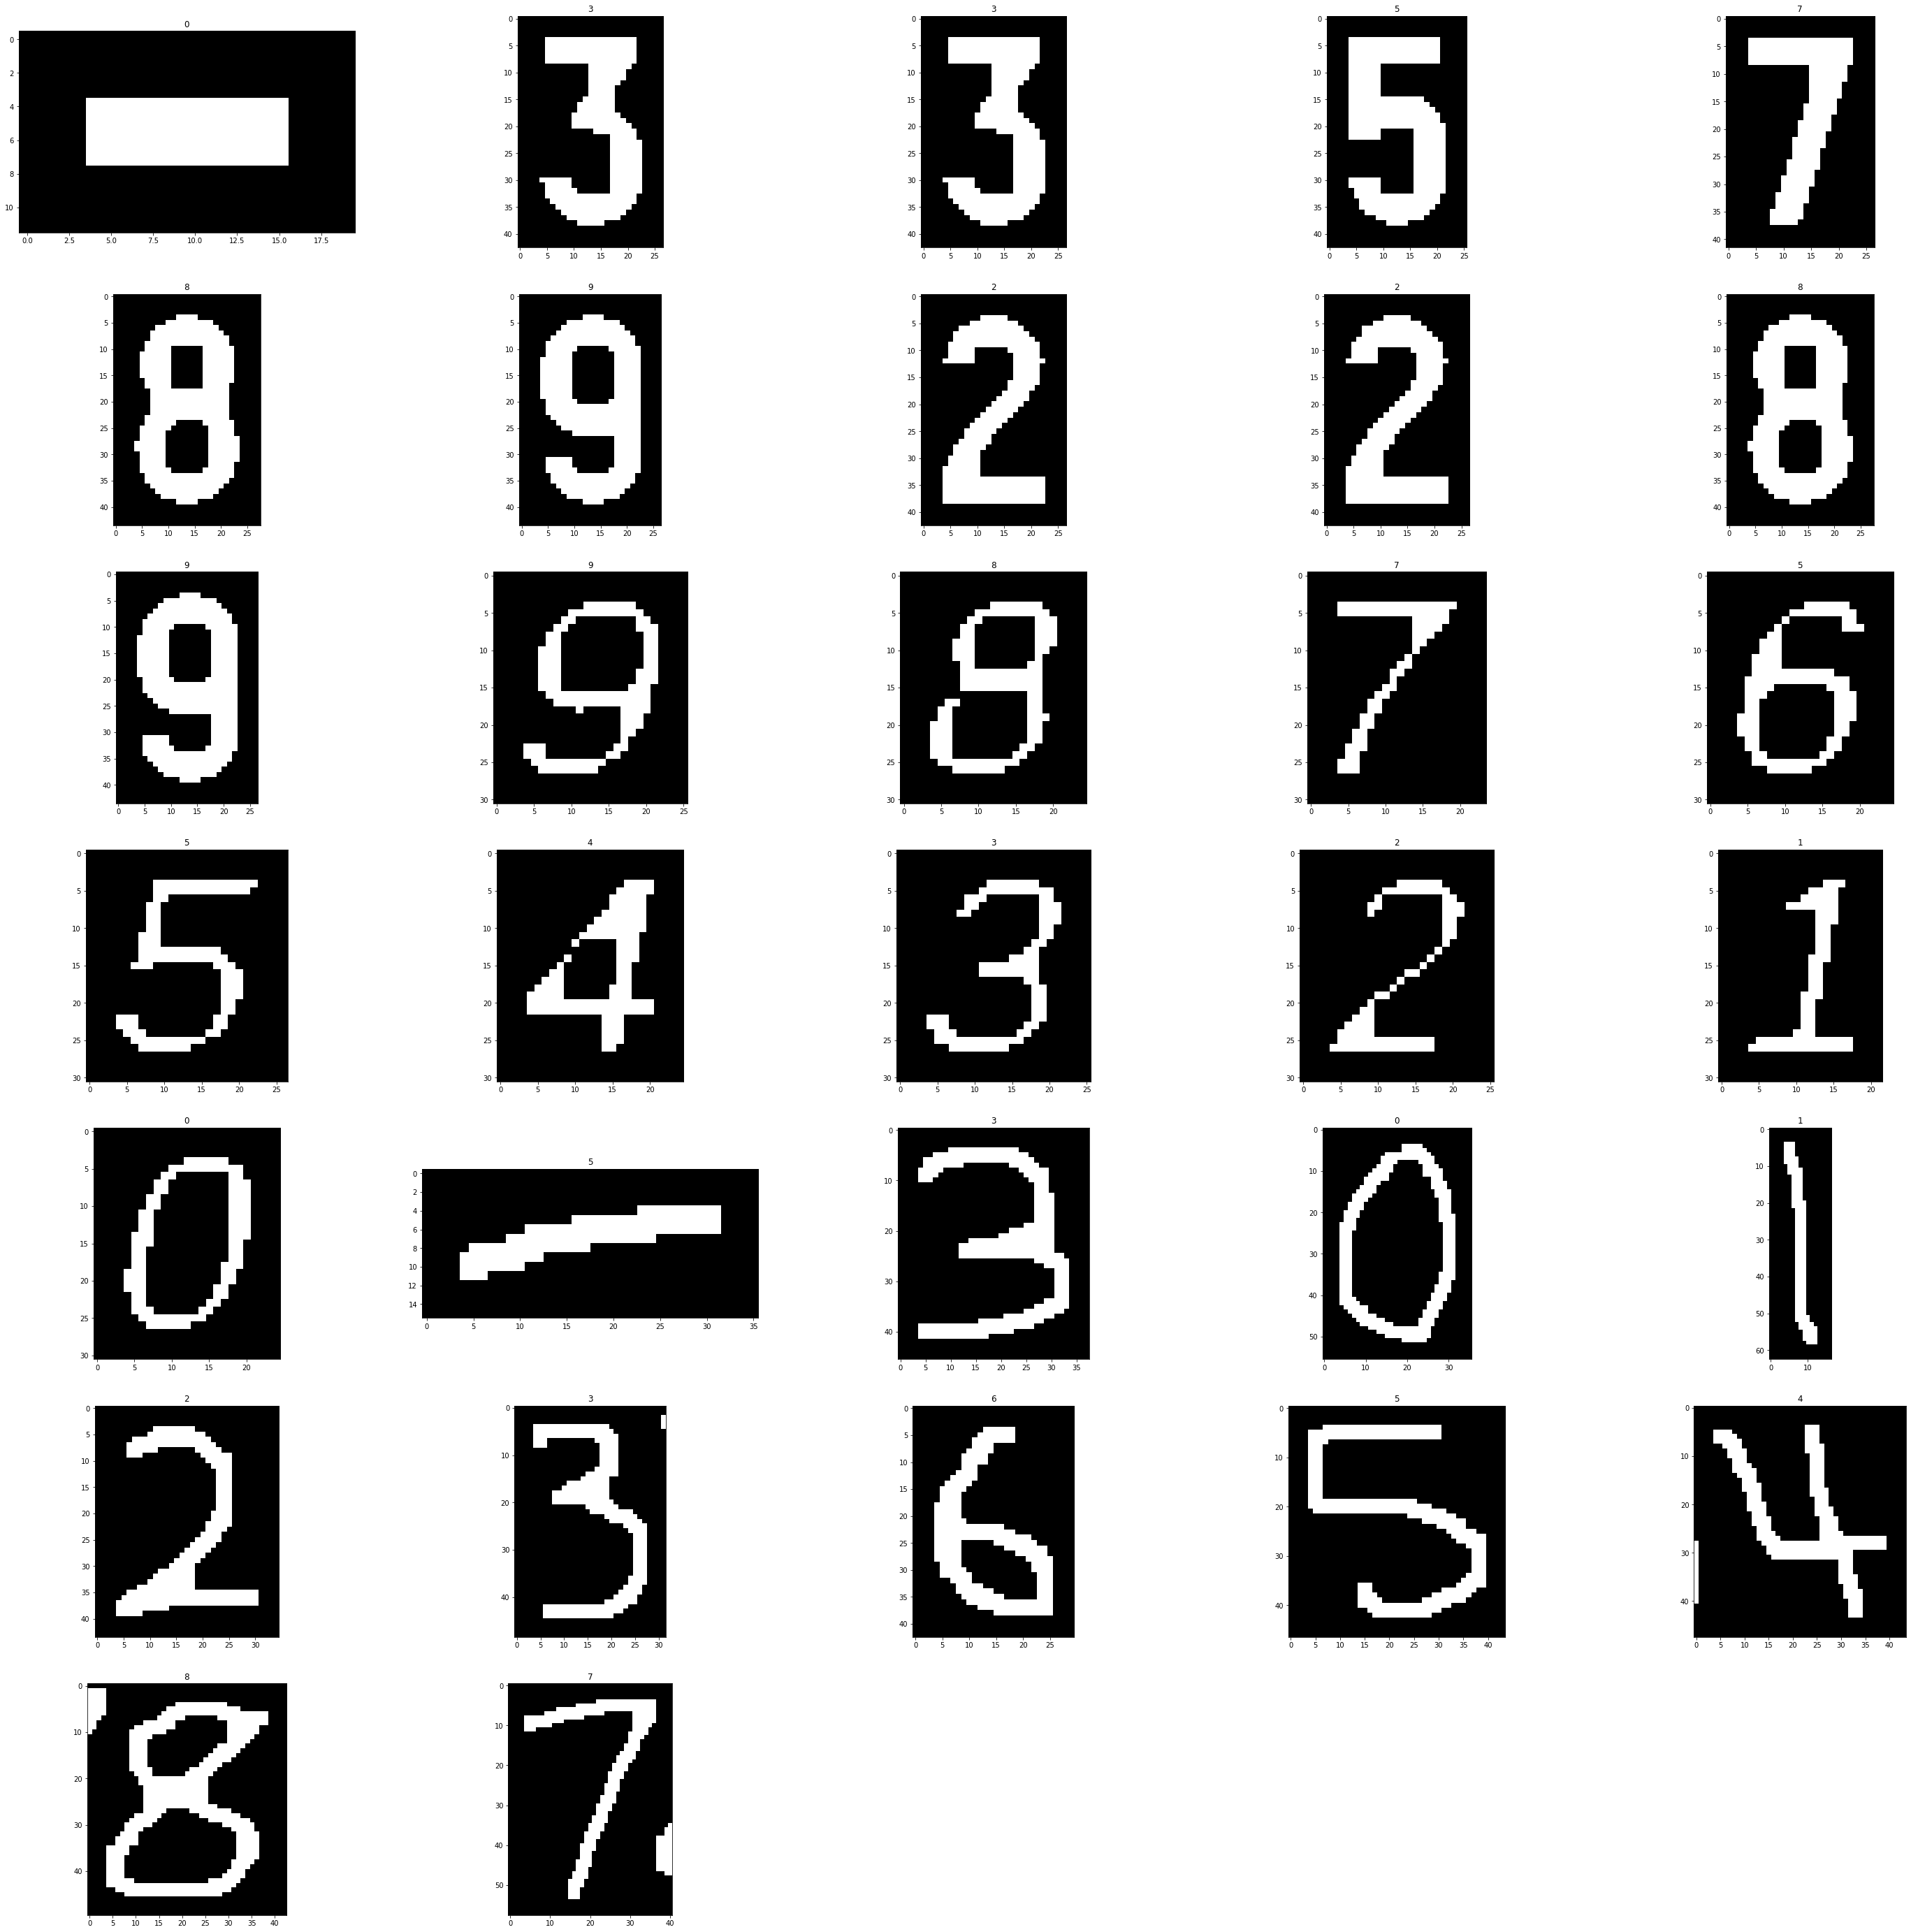

In [15]:
img_ori = cv2.imread("phone_number.jpg")

for idx, cnt in enumerate(contours):    
    x, y, w, h = cv2.boundingRect(cnt)

    # Cropping the text block for giving input to OCR
    cropped_img = processed_img[y-4:y+h+4, x-4:x+w+4]

    # Prepare the plot
    if idx == 0:
        num_of_predictions = len(contours)
        fig = plt.figure(figsize=(50,50))

    ax = fig.add_subplot(round(num_of_predictions/5)+1, 5, idx + 1)
    ax.imshow(cropped_img, cmap='gray')

    # Resize image
    resized_img = cv2.resize(cropped_img, (28, 28))
    test_img = np.reshape(resized_img, (1, 28, 28, 1))

    # Apply OCR on the cropped image
    predicted_text = cnn.predict(test_img/255)
    ax.title.set_text(np.argmax(predicted_text))

    # Drawing rectangles on copied image
    rect = cv2.rectangle(img_ori, (x-4, y-4), (x + w + 4, y + h + 4), (0, 255, 0), 2)
    new_image = cv2.putText(img_ori, str(np.argmax(predicted_text)), (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)

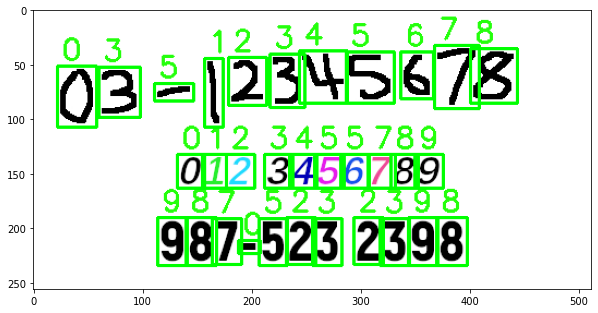

In [16]:
plt.figure(figsize=(10,10))
plt.imshow(new_image)

Above shows the result of our OCR model. Most of the numbers are identified correctly, except for the "-" because it isn't in our training set.

### Future Improvement <a name="future-improvement"></a>

While the model is able to recognize the digits reasonably well, I believe that a lot more work needs to be done before we can deploy the model into production.

Moving forward, I'd like to train the model to recognize the alphabets. Potential data sets could be [Char74K](#http://www.ee.surrey.ac.uk/CVSSP/demos/chars74k/). We can also explore generating our own data set as outlined in the research paper, [Training A Neural Network Using Synthetically Generated Data](#https://www.diva-portal.org/smash/get/diva2:1464537/FULLTEXT01.pdf) by Fredrik Diffner and Hovig Manjikian.

As our training dataset grow larger, I'd imagine that we would run into shortage of RAM. This is because our training set is loaded into our computer memory during training time before fitting onto the model. We may need to consider implementing an incremental learning approach. It allows us to train our model in smaller batches while simultaneously reducing the impact of catastrophic forgetting. The research paper, [End-to-End Incremental Learning](#https://www.researchgate.net/profile/Mohammed-Mahmoud-2/post/What-are-the-techniques-for-incremental-training-of-Convolutional-Neural-Networks-without-doing-full-training-as-new-classes-are-added-to-data/attachment/5cdadcfa3843b0b98252d181/AS%3A758480663236610%401557847290250/download/Francisco_M._Castro_End-to-End_Incremental_Learning_ECCV_2018_paper.pdf) by Francisco M. Castro demonstrated how this could be achieved with a simple custom loss function and representative memory.